# Monet GAN Project

Intro here ...

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

Tensorflow Hub  
https://www.tensorflow.org/tutorials/generative/style_transfer#fast_style_transfer_using_tf-hub  
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial  
https://machinelearningmastery.com/cyclegan-tutorial-with-keras/

## Data Summary

#### Data Source
- Data was imported from the 'I’m Something of a Painter Myself' Kaggle competition.
- 2 folders provided from Kaggle: monet_jpg and photo_jpg. These will be converted to Tensorflow record files so it's easier to do work with

Reference:  
Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

#### Import Datasets

In [2]:
# Paths to data folders and labels file
monet_images_path = './monet_jpg/'
photos_images_path  = './photo_jpg/'

# Create a list of the file paths to the images in the monet and photos folders
monet_file_paths = glob.glob(os.path.join(monet_images_path, '*.jpg'))
photos_file_paths = glob.glob(os.path.join(photos_images_path, '*.jpg'))

print(f'Count of Monet paintings = {len(monet_file_paths):,}\nCount of photo images = {len(photos_file_paths):,}')

Count of Monet paintings = 300
Count of photo images = 7,038


#### Configure Constant Variables
- Define the exogenous varibles that will be used throughout the modeling and analysis.

In [8]:
# Set random seeds for reproducibility
# tf.random.set_seed(666)
np.random.seed(666)

# # Image config
IMG_SIZE = 256 # Images dimensions (256 x 256 pixels)
CHANNELS = 3  # RGB images
# SAMPLE_SIZE = 55000 # Number of image samples used for training

# # Training config
BATCH_SIZE = 64 # Training batch size
# AUTOTUNE = tf.data.AUTOTUNE # Let tf.data choose parallelism
# MAX_EPOCHS = 30

# Ignore warnings
# warnings.simplefilter('ignore')

## EDA

#### RBG Histogram Distributions
- ...

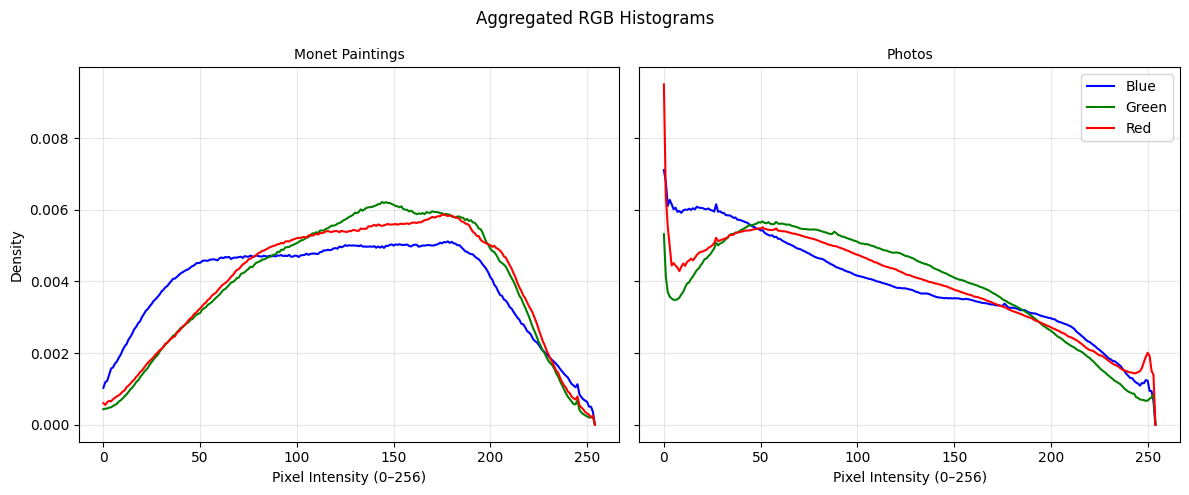

In [ ]:
# Function to create RGB histogram data
def get_histogram_data(files):
    hists = np.zeros((3, 255), dtype=np.float64)
    for path in files:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        for ch in range(3):
            hists[ch] += cv2.calcHist([img], [ch], None, [255], [1, 255]).ravel()
    return hists

# Get histogram data
monet_files_hist_data = get_histogram_data(monet_file_paths)
photos_files_hist_data = get_histogram_data(photos_file_paths)

monet_files_probability_data = monet_files_hist_data / monet_files_hist_data.sum(axis=1, keepdims=True)
photos_files_probability_data = photos_files_hist_data / photos_files_hist_data.sum(axis=1, keepdims=True)

# Plot RGB Histograms
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

ax0.plot(monet_files_probability_data[0], 'b', label='Blue')
ax0.plot(monet_files_probability_data[1], 'g', label='Green')
ax0.plot(monet_files_probability_data[2], 'r', label='Red')
ax0.set_title('Monet Paintings', fontdict={'fontsize':10})
ax0.set_xlabel('Pixel Intensity (0–256)')
ax0.set_ylabel('Density')
ax0.grid(True, alpha=0.3)

ax1.plot(photos_files_probability_data[0], 'b', label='Blue')
ax1.plot(photos_files_probability_data[1], 'g', label='Green')
ax1.plot(photos_files_probability_data[2], 'r', label='Red')
ax1.set_title('Photos', fontdict={'fontsize':10})
ax1.set_xlabel('Pixel Intensity (0–256)')
ax1.grid(True, alpha=0.3)
ax1.legend()

plt.suptitle(f'Aggregated RGB Histograms')
plt.tight_layout()
plt.show()

#### Similar Looking Pictures  
- ...

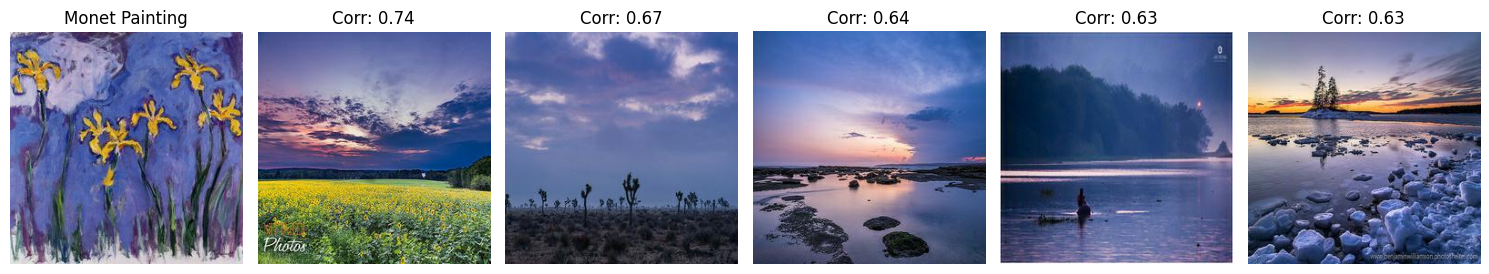

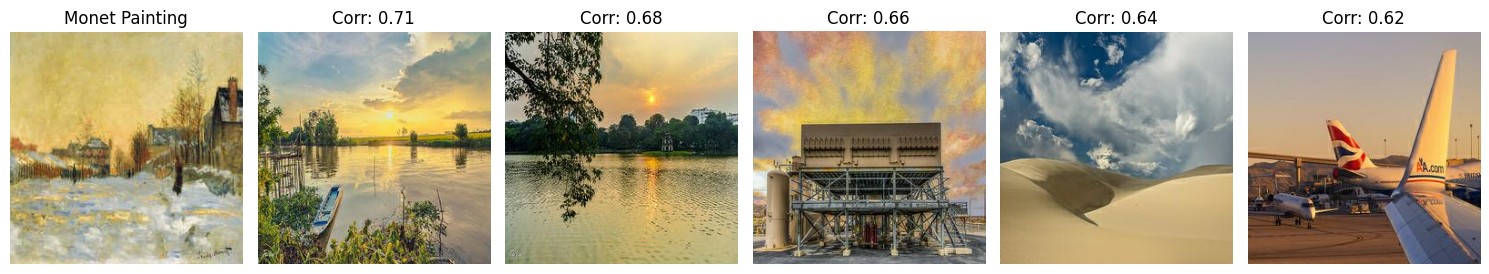

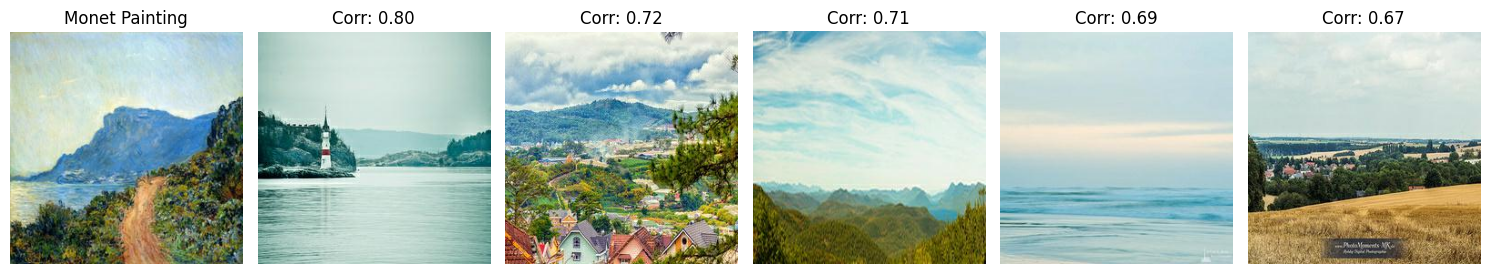

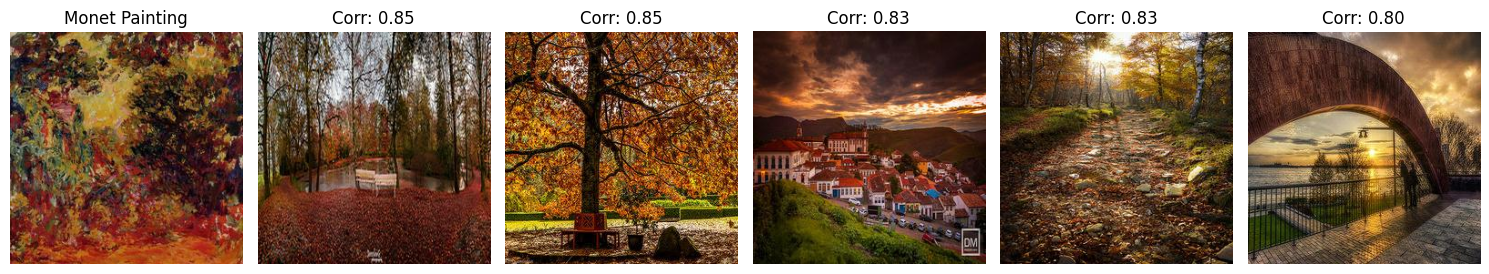

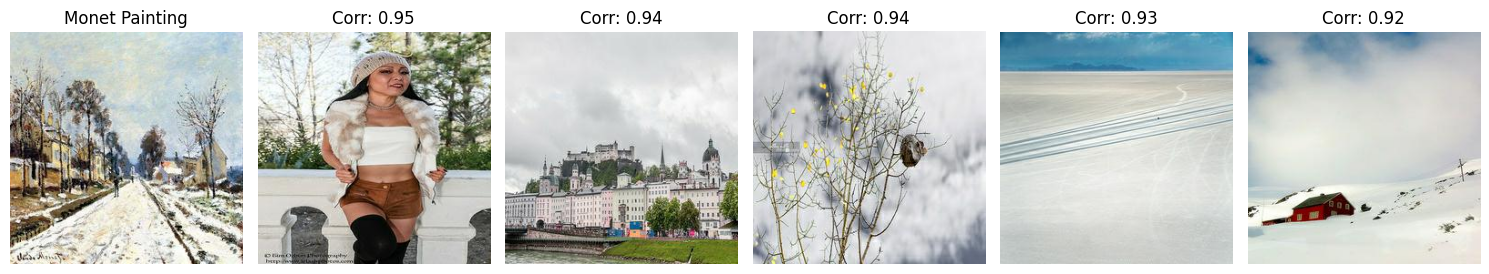

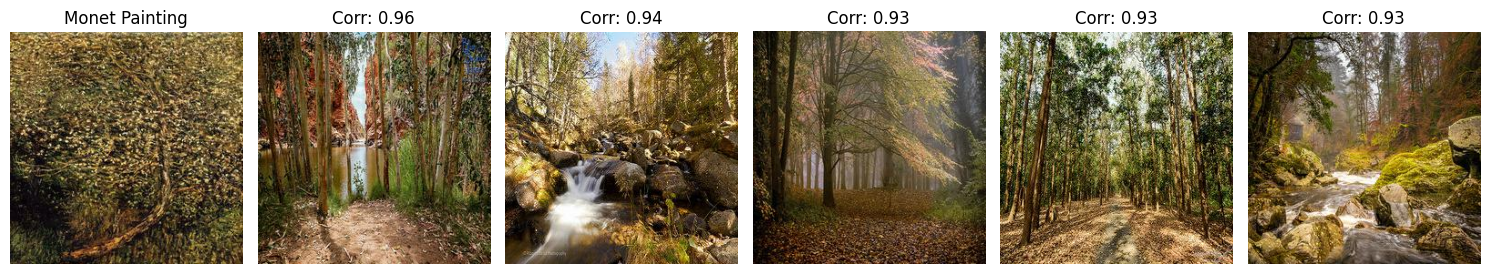

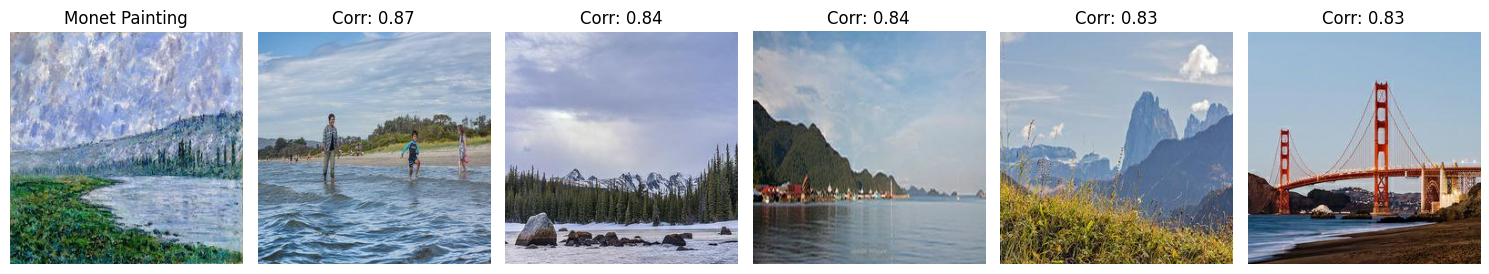

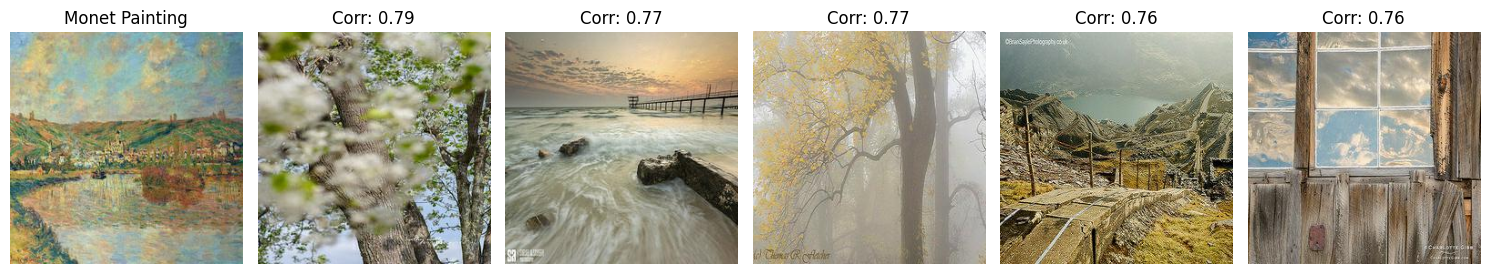

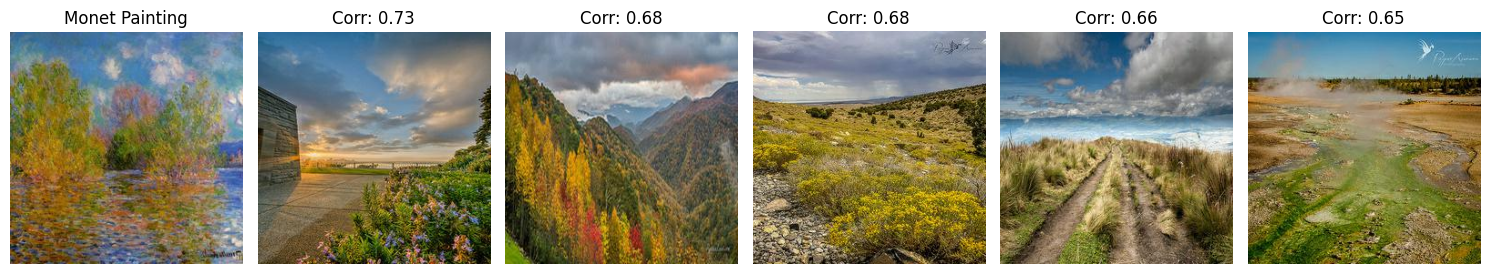

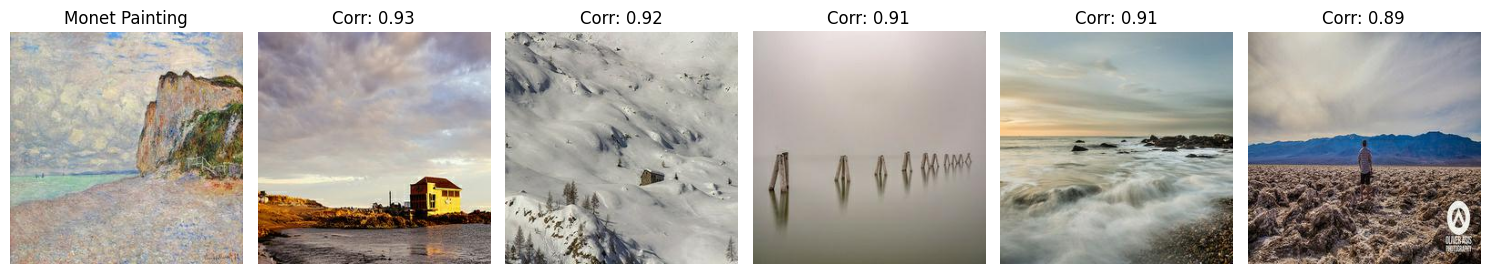

In [ ]:
# Function to plot similar photos based on color histogram similarity
def plot_similar_photos(monet_file_paths, photos_file_paths):

    # Function to compute color histogram
    def compute_histogram(image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

    # Select 10 random Monet paintings
    random_monet_paths = random.sample(monet_file_paths, 10)

    for monet_path in random_monet_paths:
        monet_hist = compute_histogram(monet_path)
        similarities = []
        for photo_path in photos_file_paths:
            photo_hist = compute_histogram(photo_path)
            correlation = cv2.compareHist(monet_hist, photo_hist, cv2.HISTCMP_CORREL)
            similarities.append((photo_path, correlation))

        # Sort photos by similarity (correlation) in descending order
        similarities.sort(key=lambda x: x[1], reverse=True)
        top_similar_photos = similarities[:5]

        # Plotting
        plt.figure(figsize=(15, 5))
        monet_image = cv2.imread(monet_path)
        monet_image = cv2.cvtColor(monet_image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 6, 1)
        plt.imshow(monet_image)
        plt.axis('off')
        plt.title('Monet Painting')

        for i, (photo_path, corr) in enumerate(top_similar_photos):
            photo_image = cv2.imread(photo_path)
            photo_image = cv2.cvtColor(photo_image, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 6, i + 2)
            plt.imshow(photo_image)
            plt.axis('off')
            plt.title(f'Corr: {corr:.2f}')

        plt.tight_layout()
        plt.show()


plot_similar_photos(monet_file_paths, photos_file_paths)

#### Create Training, Validation, and Test Datasets
- ...

In [108]:
img = random.sample(monet_file_paths, 1)
img = cv2.imread(img[0])

# plt.imshow(img[:, :, :])

In [11]:
# Numpy function used to read and resize images
def _read_and_resize(path):
    path = path.decode('utf-8')
    img = cv2.imread(path)       
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img.astype(np.float32)

#Function to load and preprocess each image
def load_image(path):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])  # static shape required by Keras
    return img

# Create Monet and photo tf.data.Dataset instances
monet_ds = tf.data.Dataset.from_tensor_slices((monet_file_paths))
photos_ds = tf.data.Dataset.from_tensor_slices((photos_file_paths))

# Create training dataset
monet_ds = (
    monet_ds
    # .shuffle(buffer_size=len(monet_file_paths))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nMonet dataset of {len(monet_file_paths):,} paintings has been created.')

# Create validation dataset
photos_ds = (
    photos_ds
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nPhotos dataset of {len(photos_file_paths):,} images has been created.')


Monet dataset of 300 paintings has been created.

Photos dataset of 7,038 images has been created.


#### Plan of Analysis
- ...

## Modeling

## Hyperparameter Tuning

## Other Models

## Results & Analysis

## Conclusion